
# 项目：调查数据集（TMDb电影数据）

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介
本数据集中包含 1 万条电影信息，信息来源为“电影数据库”（TMDb，The Movie Database），包括用户评分和票房。“演职人员 (cast)”、“电影类别 (genres)”等数据列包含由竖线字符（|）分隔的多个数值。“演职人员 (cast) ”列中有一些奇怪的字符。先不要清洁它们，你可以保持原样，不去管它们。

提问：
每年最受欢迎的电影类别是哪些？
票房高的电影有哪些特点？

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## 数据整理



### 常规属性

In [2]:
# 加载数据，并打印前几行

df = pd.read_csv('tmdb-movies.csv')
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


In [3]:
# 检查数据类型

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

发现类型不匹配： budget列为int型，budget_adj列为float类型

发现以下列存在数据缺失：

imdb_id imdb ID

cast 演职人员

homepage 电影主页

director 导演

tagline 标语

keywords 关键字

overview 概述

genres 电影类别

production_companies 出品公司

In [4]:
# 检查有无重复记录

sum(df.duplicated())

1

In [5]:
# 检查是否有空值

df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64



### 数据清理（）

In [6]:
# 丢弃功能重复的列 budget 和 revenue，只保留budget_adj 和 revenue_adj 列

df.drop(['budget','revenue'], axis=1, inplace=True)

In [7]:
# 修正数据类型，
# 把budget_adj 和 revenue_adj 列从浮点类型转换成整形

df['budget_adj'] = df['budget_adj'].astype(int)
df['revenue_adj'] = df['revenue_adj'].astype(int)

In [8]:
# 将 budget_adj 重命名为 budget

df = df.rename(columns={'budget_adj':'budget'})

In [9]:
# 将 revenue_adj 重命名为 revenue

df = df.rename(columns={'revenue_adj':'revenue'})

In [10]:
# 解决数据冗余
# 去重
df.drop_duplicates(inplace=True)

In [11]:
# 解决数据缺失
# 删除空值行

df.dropna(axis=0, how='all', inplace=True)

In [12]:
# 解决数据缺失
# 删除空值太多、且和问题无关的列 homepage，tagline, keywords, production_companies

df.drop(['homepage','tagline','keywords','production_companies'], axis=1, inplace=True)

In [16]:
# 清理Revenue 为0的行

df= df.query('revenue != 0')

In [19]:
# “电影类别 (genres)”列包含由竖线字符（|）分隔的多个数值
# 拆分 genres 列为多行，以便于找出最受欢迎的电影类别

df = df.drop('genres', axis=1).join(df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('genres'))

<a id='eda'></a>
## 探索性数据分析


### 研究问题 1（每年最受欢迎的电影类别是哪些？ 这些类别和票房是什么关系？）

In [20]:
# 按年分组，找出每年最受欢迎的电影类别

df.groupby('release_year').apply(lambda t: t[t.popularity==t.popularity.max()]).loc[:,['release_year','genres','popularity']]

release_year           genres  popularity
release_year                                                 
1960         10141          1960            Drama    2.610362
             10141          1960           Horror    2.610362
             10141          1960         Thriller    2.610362
1961         10110          1961        Adventure    2.631987
             10110          1961        Animation    2.631987
             10110          1961           Comedy    2.631987
             10110          1961           Family    2.631987
1962         9849           1962        Adventure    3.170651
             9849           1962           Action    3.170651
             9849           1962         Thriller    3.170651
1963         10438          1963           Action    2.508235
             10438          1963         Thriller    2.508235
             10438          1963        Adventure    2.508235
1964         9881           1964        Adventure    3.153791
             9881           1964           Action    3.153791
             9881           1964         Thriller    3.153791
1965         10689          1965        Adventure    1.910465
             10689          1965           Action    1.910465
             10689          1965         Thriller    1.910465
1966         10822          1966            Drama    0.670274
1967         10398          1967           Family    2.550704
             10398          1967        Animation    2.550704
             10398          1967        Adventure    2.550704
1968         9719           1968  Science Fiction    3.309196
             9719           1968          Mystery    3.309196
             9719           1968        Adventure    3.309196
1969         10724          1969        Adventure    1.778746
             10724          1969           Action    1.778746
             10724          1969         Thriller    1.778746
1970         10648          1970        Animation    1.936962
...                          ...              ...         ...
2007         7387           2007           Action    4.965391
2008         2875           2008            Drama    8.466668
             2875           2008           Action    8.466668
             2875           2008            Crime    8.466668
             2875           2008         Thriller    8.466668
2009         1386           2009           Action    9.432768
             1386           2009        Adventure    9.432768
             1386           2009          Fantasy    9.432768
             1386           2009  Science Fiction    9.432768
2010         1919           2010           Action    9.363643
             1919           2010         Thriller    9.363643
             1919           2010  Science Fiction    9.363643
             1919           2010          Mystery    9.363643
             1919           2010        Adventure    9.363643
2011         3372           2011           Action    7.959228
             3372           2011        Adventure    7.959228
             3372           2011  Science Fiction    7.959228
2012         4361           2012  Science Fiction    7.637767
             4361           2012           Action    7.637767
             4361           2012        Adventure    7.637767
2013         5422           2013        Animation    6.112766
             5422           2013        Adventure    6.112766
             5422           2013           Family    6.112766
2014         629            2014        Adventure   24.949134
             629            2014            Drama   24.949134
             629            2014  Science Fiction   24.949134
2015         0              2015           Action   32.985763
             0              2015        Adventure   32.985763
             0              2015  Science Fiction   32.985763
             0              2015         Thriller   32.985763

[164 rows x 3 columns]

以上是每年最受欢迎的电影类别

Text(0.5,1,'Genres VS Average Revenue')

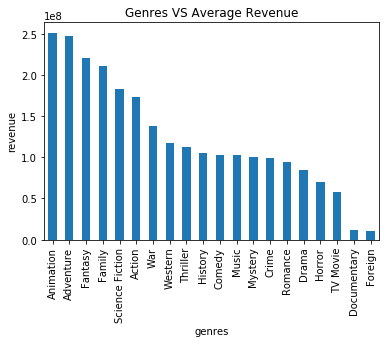

In [46]:
# 使用可视化进一步分析电影类别和票房的关系

df.groupby('genres')['revenue'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('revenue')
plt.title('Genres VS Average Revenue')

动画类、冒险类、奇幻类的电影的平均票房较高
而记录片、外国片的平均票房较低

### 研究问题 2（票房高的电影有哪些特点？）

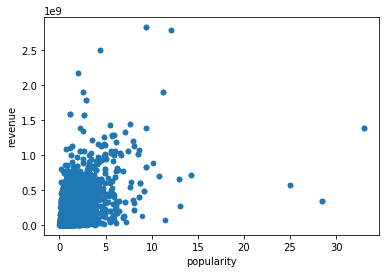

In [48]:
# 票房和受欢迎程度的散点图

df.plot(x='popularity', y='revenue', kind='scatter');

由图可知，票房和受欢迎程度之间没有必然关系

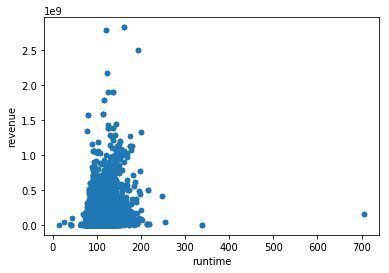

In [49]:
# 票房和电影时长的散点图

df.plot(x='runtime', y='revenue', kind='scatter');

由图可知，票房和电影时长之间没有必然关系

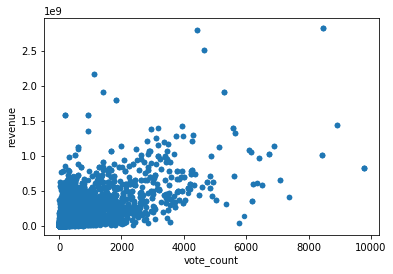

In [51]:
# 票房和得票数的散点图

df.plot(x='vote_count', y='revenue', kind='scatter');

由图可知，票房和得票数没有必然关系

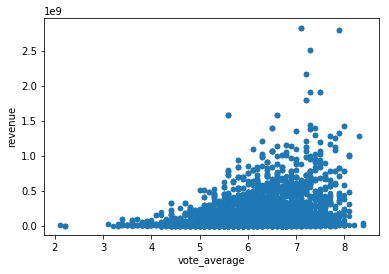

In [52]:
# 票房和平均得分的散点图

df.plot(x='vote_average', y='revenue', kind='scatter');

由图可知，得分越高，往往票房也越高

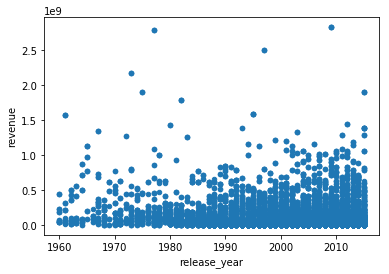

In [53]:
# 票房和发行年份的散点图

df.plot(x='release_year', y='revenue', kind='scatter');

由图可知，随着发行年份越往后，票房逐渐上升

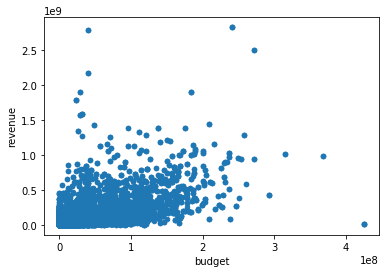

In [55]:
# 票房和成本的散点图

df.plot(x='budget', y='revenue', kind='scatter');

由图可知，成本和票房没有必然关联

综上所述，票房高的电影有这样的特点：

1. 平均得分(vote_average)越高，票房越高
2. 越是近的年份(release_year)，票房越高

<a id='conclusions'></a>
## 结论

本调查主要分析了两大问题：
1，每年受欢迎的电影类别有哪些，类别和票房的大致关系
2，票房高的电影有哪些特点。


局限性在于：
1. 数据列中有不少列是空值。由于是字符串类型，只能做丢弃处理，无法像数值类型那样可以求均值后作填充处理
2. 未给出电影票房与非数值特征，如制片公司，导演，演职人员之间的关系

In [57]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255